# CKKS Encrypted Inference Evaluation

Evaluate CKKS-encrypted logistic regression inference on the four synthetic datasets (32/88/93/181 dimensions) and compare to plaintext baselines.

In [1]:
# Imports and configuration
import json
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tenseal as ts
from sklearn.metrics import roc_auc_score, brier_score_loss, roc_curve

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('muted')

DATA_DIR = Path('data/synthetic')
DATA_DIR.mkdir(parents=True, exist_ok=True)
BASELINE_DIR = Path('artifacts/plaintext_baseline')
BASELINE_DIR.mkdir(parents=True, exist_ok=True)
ARTIFACT_DIR = Path('artifacts/encrypted_inference')
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)
ARTIFACT_INDEX_PATH = ARTIFACT_DIR / 'artifact_index.json'

DATASETS = [
    {'name': '32-dim', 'folder': '32dim', 'description': 'Fast baseline acoustic'},
    {'name': '88-dim', 'folder': '88dim', 'description': 'Realistic acoustic (eGEMAPS-like)'},
    {'name': '93-dim', 'folder': '93dim', 'description': 'LIWC-style linguistic'},
    {'name': '181-dim', 'folder': '181dim', 'description': 'Multimodal acoustic + linguistic'}
]

CKKS_CONFIG = {
    'poly_modulus_degree': 8192,
    'coeff_mod_bit_sizes': [60, 40, 40, 60],
    'scale_bits': 40
}

ERRSTATE_KWARGS = dict(divide='ignore', invalid='ignore', over='ignore')

print('Artifacts directory:', ARTIFACT_DIR.resolve())

Artifacts directory: /Users/eve/Documents/Projects/SCRAM/experiments/artifacts/encrypted_inference


## Helper Functions

In [2]:
def ensure_finite(label, array):
    if not np.all(np.isfinite(array)):
        raise ValueError(f"{label} contains non-finite values")
    return array


def resolve_baseline_folder(folder_name):
    candidate = BASELINE_DIR / folder_name
    if candidate.exists():
        return candidate
    raise FileNotFoundError(f'Baseline artifacts not found for {folder_name}')


def load_dataset(folder_name):
    folder = DATA_DIR / folder_name
    X_test = ensure_finite('X_test', np.load(folder / 'X_test.npy'))
    y_test = ensure_finite('y_test', np.load(folder / 'y_test.npy'))
    return X_test, y_test


def load_baseline(folder_name):
    folder = resolve_baseline_folder(folder_name)
    coef = ensure_finite('coefficients', np.load(folder / 'coefficients.npy'))
    with open(folder / 'intercept.txt', 'r') as f:
        intercept = float(f.read().strip())
    with open(folder / 'metrics.json', 'r') as f:
        metrics = json.load(f)
    return coef, intercept, metrics, folder


def create_ckks_context(config):
    context = ts.context(
        ts.SCHEME_TYPE.CKKS,
        poly_modulus_degree=config['poly_modulus_degree'],
        coeff_mod_bit_sizes=config['coeff_mod_bit_sizes']
    )
    context.global_scale = 2 ** config['scale_bits']
    context.generate_galois_keys()
    return context


def run_plaintext_inference(X, coef, intercept):
    latencies = []
    logits = []
    for sample in X:
        t0 = time.perf_counter()
        with np.errstate(**ERRSTATE_KWARGS):
            logit = float(np.dot(sample, coef) + intercept)
        latencies.append((time.perf_counter() - t0) * 1000)
        logits.append(logit)
    return ensure_finite('plaintext logits', np.array(logits)), ensure_finite('plaintext latencies', np.array(latencies))


def sigmoid(values):
    with np.errstate(**ERRSTATE_KWARGS):
        probs = 1.0 / (1.0 + np.exp(-values))
    return ensure_finite('sigmoid output', probs)


def run_encrypted_inference(X, coef, intercept, context):
    coef_enc = ts.ckks_vector(context, coef.tolist())
    latencies = []
    logits = []
    for sample in X:
        t0 = time.perf_counter()
        x_enc = ts.ckks_vector(context, sample.tolist())
        logit_enc = x_enc.dot(coef_enc) + intercept
        logits.append(logit_enc.decrypt()[0])
        latencies.append((time.perf_counter() - t0) * 1000)
    return ensure_finite('encrypted logits', np.array(logits)), ensure_finite('latencies', np.array(latencies))


ckks_context = create_ckks_context(CKKS_CONFIG)
print('CKKS context initialized.')

CKKS context initialized.


## Statistical Evaluation Functions

Paired bootstrap non-inferiority testing for plaintext vs encrypted comparison.

In [3]:
def paired_bootstrap_noninferiority(y_true, y_scores_plain, y_scores_enc,
                                    n_boot=5000, margin=0.01, alpha=0.05, random_state=None):
    """
    Paired bootstrap test for non-inferiority.
    
    H0: delta = AUC_plain - AUC_enc >= margin (encrypted is inferior by margin)
    H1: delta < margin (encrypted is non-inferior)
    
    Returns:
        - delta_hat: observed difference (plain - enc)
        - ci: (lower, upper) percentile CI of delta
        - p_value: one-sided p-value (proportion of bootstrap deltas >= margin)
        - deltas: full bootstrap distribution for plotting
        - non_inferior: True if upper CI < margin
    """
    rng = np.random.RandomState(random_state)
    y_true = np.asarray(y_true)
    n = len(y_true)
    
    # Observed delta
    auc_plain = roc_auc_score(y_true, y_scores_plain)
    auc_enc = roc_auc_score(y_true, y_scores_enc)
    delta_hat = auc_plain - auc_enc
    
    # Bootstrap resampling (paired)
    deltas = []
    for _ in range(n_boot):
        idx = rng.randint(0, n, size=n)
        if len(np.unique(y_true[idx])) < 2:
            continue  # skip degenerate resamples
        a_p = roc_auc_score(y_true[idx], y_scores_plain[idx])
        a_e = roc_auc_score(y_true[idx], y_scores_enc[idx])
        deltas.append(a_p - a_e)
    
    deltas = np.array(deltas)
    lower = np.percentile(deltas, 100 * (alpha/2))
    upper = np.percentile(deltas, 100 * (1 - alpha/2))
    p_value = np.mean(deltas >= margin)
    non_inferior = (upper < margin)
    
    return {
        'delta_hat': float(delta_hat),
        'ci_lower': float(lower),
        'ci_upper': float(upper),
        'p_value': float(p_value),
        'n_boot': len(deltas),
        'non_inferior': non_inferior,
        'deltas': deltas
    }


print('Statistical evaluation functions ready.')

Statistical evaluation functions ready.


## Evaluate Datasets

In [4]:
records = []
roc_plots = []
artifact_records = []
noninferiority_data = []  # Store data for paired bootstrap testing

for spec in DATASETS:
    print(f"Processing {spec['name']} ({spec['description']}) ...")
    X_test, y_test = load_dataset(spec['folder'])
    coef, intercept, baseline_metrics, baseline_folder = load_baseline(spec['folder'])

    logits_plain, latencies_plain = run_plaintext_inference(X_test, coef, intercept)
    probs_plain = sigmoid(logits_plain)

    logits_enc, latencies_enc = run_encrypted_inference(X_test, coef, intercept, ckks_context)
    probs_enc = sigmoid(logits_enc)

    auc_plain = roc_auc_score(y_test, probs_plain)
    auc_enc = roc_auc_score(y_test, probs_enc)
    brier_plain = brier_score_loss(y_test, probs_plain)
    brier_enc = brier_score_loss(y_test, probs_enc)

    result = {
        'Dataset': spec['name'],
        'Description': spec['description'],
        'Dimensionality': X_test.shape[1],
        'auc_plain': auc_plain,
        'auc_encrypted': auc_enc,
        'auc_delta': abs(auc_enc - auc_plain),
        'brier_plain': brier_plain,
        'brier_encrypted': brier_enc,
        'latency_plain_mean_ms': float(latencies_plain.mean()),
        'latency_plain_median_ms': float(np.median(latencies_plain)),
        'latency_plain_p95_ms': float(np.percentile(latencies_plain, 95)),
        'latency_mean_ms': float(latencies_enc.mean()),
        'latency_median_ms': float(np.median(latencies_enc)),
        'latency_p95_ms': float(np.percentile(latencies_enc, 95)),
        'logit_mae': float(np.mean(np.abs(logits_enc - logits_plain))),
        'plaintext_auc_baseline': baseline_metrics.get('auc_test'),
        'plaintext_brier_baseline': baseline_metrics.get('brier_test')
    }
    records.append(result)

    fpr_plain, tpr_plain, _ = roc_curve(y_test, probs_plain)
    fpr_enc, tpr_enc, _ = roc_curve(y_test, probs_enc)
    roc_plots.append({
        'label': spec['name'],
        'fpr_plain': fpr_plain,
        'tpr_plain': tpr_plain,
        'fpr_enc': fpr_enc,
        'tpr_enc': tpr_enc
    })

    dim_dir = ARTIFACT_DIR / spec['folder']
    dim_dir.mkdir(parents=True, exist_ok=True)
    np.save(dim_dir / 'logits_encrypted.npy', logits_enc)
    np.save(dim_dir / 'probs_encrypted.npy', probs_enc)
    np.save(dim_dir / 'latencies_encrypted.npy', latencies_enc)
    np.save(dim_dir / 'latencies_plain.npy', latencies_plain)
    with open(dim_dir / 'metrics.json', 'w') as f:
        json.dump(result, f, indent=2)

    artifact_records.append({
        'dataset': spec['name'],
        'description': spec['description'],
        'encrypted_metrics': str((dim_dir / 'metrics.json').as_posix()),
        'encrypted_logits': str((dim_dir / 'logits_encrypted.npy').as_posix()),
        'encrypted_probabilities': str((dim_dir / 'probs_encrypted.npy').as_posix()),
        'latencies_encrypted': str((dim_dir / 'latencies_encrypted.npy').as_posix()),
        'latencies_plain': str((dim_dir / 'latencies_plain.npy').as_posix()),
        'plaintext_metrics': str((baseline_folder / 'metrics.json').as_posix())
    })
    
    # Store for non-inferiority testing
    noninferiority_data.append({
        'dataset': spec['name'],
        'y_true': y_test,
        'probs_plain': probs_plain,
        'probs_enc': probs_enc
    })

pd.DataFrame(records)

Processing 32-dim (Fast baseline acoustic) ...
Processing 88-dim (Realistic acoustic (eGeMAPS-like)) ...
Processing 88-dim (Realistic acoustic (eGeMAPS-like)) ...
Processing 93-dim (LIWC-style linguistic) ...
Processing 93-dim (LIWC-style linguistic) ...
Processing 181-dim (Multimodal acoustic + linguistic) ...
Processing 181-dim (Multimodal acoustic + linguistic) ...


,Dataset,Description,Dimensionality,auc_plain,auc_encrypted,auc_delta,brier_plain,brier_encrypted,latency_plain_mean_ms,latency_plain_median_ms,latency_plain_p95_ms,latency_mean_ms,latency_median_ms,latency_p95_ms,logit_mae,plaintext_auc_baseline,plaintext_brier_baseline
0,32-dim,Fast baseline acoustic,32,0.902525,0.902525,0.0,0.127099,0.127099,0.001275,0.001125,0.001209,6.069035,6.051604,6.237716,0.000002,0.902525,0.127099
1,88-dim,Realistic acoustic (eGeMAPS-like),88,0.976275,0.976275,0.0,0.059006,0.059006,0.001077,0.001083,0.001166,11.881324,11.753187,12.135817,0.000004,0.976275,0.059006
2,93-dim,LIWC-style linguistic,93,0.959600,0.959600,0.0,0.078756,0.078756,0.001088,0.001042,0.001167,14.027877,14.006562,14.405893,0.000005,0.959600,0.078756
3,181-dim,Multimodal acoustic + linguistic,181,0.996500,0.996500,0.0,0.026531,0.026531,0.001099,0.001083,0.001291,15.833686,15.720396,16.124602,0.000005,0.996500,0.026531


## Visualizations

,Dataset,Description,Dimensionality,auc_plain,auc_encrypted,auc_delta,brier_plain,brier_encrypted,latency_plain_mean_ms,latency_plain_median_ms,latency_plain_p95_ms,latency_mean_ms,latency_median_ms,latency_p95_ms,logit_mae,plaintext_auc_baseline,plaintext_brier_baseline
0,32-dim,Fast baseline acoustic,32,0.902525,0.902525,0.0,0.127099,0.127099,0.001275,0.001125,0.001209,6.069035,6.051604,6.237716,0.000002,0.902525,0.127099
1,88-dim,Realistic acoustic (eGeMAPS-like),88,0.976275,0.976275,0.0,0.059006,0.059006,0.001077,0.001083,0.001166,11.881324,11.753187,12.135817,0.000004,0.976275,0.059006
2,93-dim,LIWC-style linguistic,93,0.959600,0.959600,0.0,0.078756,0.078756,0.001088,0.001042,0.001167,14.027877,14.006562,14.405893,0.000005,0.959600,0.078756
3,181-dim,Multimodal acoustic + linguistic,181,0.996500,0.996500,0.0,0.026531,0.026531,0.001099,0.001083,0.001291,15.833686,15.720396,16.124602,0.000005,0.996500,0.026531


Saved summary to artifacts/encrypted_inference/encrypted_inference_summary.csv


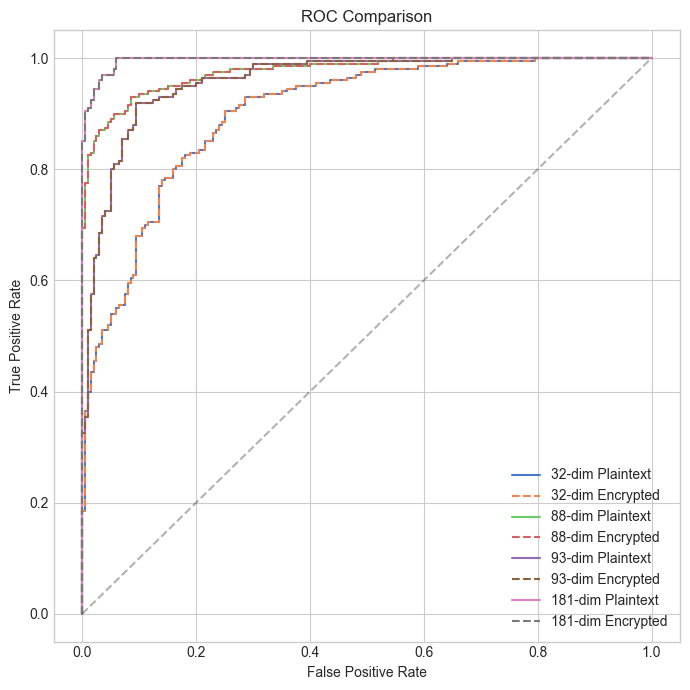

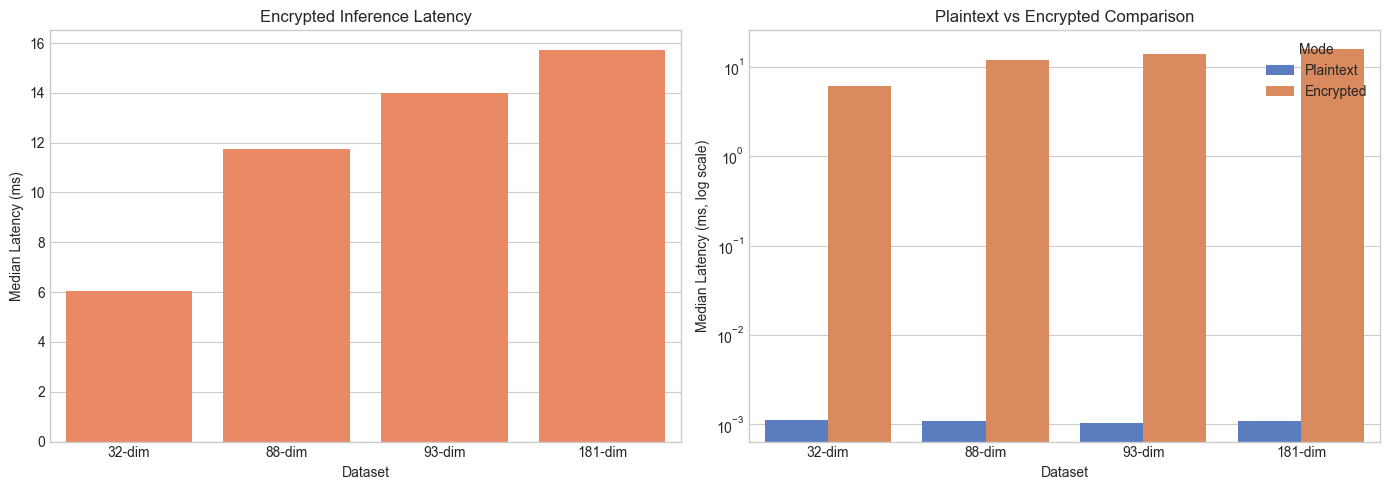

Updated artifact index at artifacts/encrypted_inference/artifact_index.json


In [5]:
summary_df = pd.DataFrame(records)
display(summary_df)
summary_path = ARTIFACT_DIR / 'encrypted_inference_summary.csv'
summary_df.to_csv(summary_path, index=False)
print('Saved summary to', summary_path)

fig, ax = plt.subplots(figsize=(7, 7))
for roc in roc_plots:
    ax.plot(roc['fpr_plain'], roc['tpr_plain'], label=f"{roc['label']} Plaintext")
    ax.plot(roc['fpr_enc'], roc['tpr_enc'], '--', label=f"{roc['label']} Encrypted")
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Comparison')
ax.legend(loc='lower right')
plt.tight_layout()
roc_path = ARTIFACT_DIR / 'roc_comparison.png'
plt.savefig(roc_path, dpi=150)
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: Encrypted only (linear scale) for detail
encrypted_only = summary_df[['Dataset', 'latency_median_ms']].copy()
encrypted_only.columns = ['Dataset', 'Latency (ms)']
sns.barplot(data=encrypted_only, x='Dataset', y='Latency (ms)', ax=ax1, color='coral')
ax1.set_ylabel('Median Latency (ms)')
ax1.set_title('Encrypted Inference Latency')
ax1.set_ylim(0, None)

# Right panel: Plaintext vs Encrypted (log scale) for comparison
latency_long = summary_df.melt(
    id_vars=['Dataset'],
    value_vars=['latency_plain_median_ms', 'latency_median_ms'],
    var_name='ModeRaw',
    value_name='Latency (ms)'
)
mode_map = {
    'latency_plain_median_ms': 'Plaintext',
    'latency_median_ms': 'Encrypted'
}
latency_long['Mode'] = latency_long['ModeRaw'].map(mode_map)
sns.barplot(data=latency_long, x='Dataset', y='Latency (ms)', hue='Mode', ax=ax2)
ax2.set_ylabel('Median Latency (ms, log scale)')
ax2.set_yscale('log')
ax2.set_title('Plaintext vs Encrypted Comparison')

plt.tight_layout()
latency_path = ARTIFACT_DIR / 'latency_bar.png'
plt.savefig(latency_path, dpi=150)
plt.show()

artifact_manifest = {
    'summary_csv': str(summary_path.as_posix()),
    'roc_figure': str(roc_path.as_posix()),
    'latency_figure': str(latency_path.as_posix()),
    'ckks_config': CKKS_CONFIG,
    'records': records,
    'artifacts': artifact_records
}
with open(ARTIFACT_INDEX_PATH, 'w') as f:
    json.dump(artifact_manifest, f, indent=2)
print('Updated artifact index at', ARTIFACT_INDEX_PATH)

## Non-Inferiority Testing

Paired bootstrap test to demonstrate encrypted model is non-inferior to plaintext (ΔAUC < 0.01).

In [8]:
# Perform paired bootstrap non-inferiority test for each dataset
print("Paired Bootstrap Non-Inferiority Test (Margin = 0.01)")
print("="*80)
print("\nH0: AUC_plain - AUC_enc >= 0.01 (encrypted is inferior)")
print("H1: AUC_plain - AUC_enc < 0.01 (encrypted is non-inferior)\n")

noninferiority_results = []

for data in noninferiority_data:
    result = paired_bootstrap_noninferiority(
        data['y_true'],
        data['probs_plain'],
        data['probs_enc'],
        n_boot=5000,
        margin=0.01,
        alpha=0.05,
        random_state=42
    )
    
    noninferiority_results.append({
        'Dataset': data['dataset'],
        'Delta_hat': result['delta_hat'],
        'CI_lower': result['ci_lower'],
        'CI_upper': result['ci_upper'],
        'P_value': result['p_value'],
        'Non_inferior': result['non_inferior']
    })
    
    print(f"{data['dataset']:8s}: Δ = {result['delta_hat']:.6f}, "
          f"95% CI = [{result['ci_lower']:.6f}, {result['ci_upper']:.6f}], "
          f"p = {result['p_value']:.4f}")
    
    if result['non_inferior']:
        print(f"NON-INFERIOR: Upper CI ({result['ci_upper']:.6f}) < margin (0.01)")
    else:
        print(f"NOT NON-INFERIOR: Upper CI ({result['ci_upper']:.6f}) >= margin (0.01)")
    print()

# Save results
noninf_df = pd.DataFrame(noninferiority_results)
noninf_path = ARTIFACT_DIR / 'noninferiority_test_results.csv'
noninf_df.to_csv(noninf_path, index=False)
print(f"\nSaved non-inferiority results to {noninf_path}")

display(noninf_df)

Paired Bootstrap Non-Inferiority Test (Margin = 0.01)

H0: AUC_plain - AUC_enc >= 0.01 (encrypted is inferior)
H1: AUC_plain - AUC_enc < 0.01 (encrypted is non-inferior)

32-dim  : Δ = 0.000000, 95% CI = [0.000000, 0.000000], p = 0.0000
NON-INFERIOR: Upper CI (0.000000) < margin (0.01)

32-dim  : Δ = 0.000000, 95% CI = [0.000000, 0.000000], p = 0.0000
NON-INFERIOR: Upper CI (0.000000) < margin (0.01)

88-dim  : Δ = 0.000000, 95% CI = [0.000000, 0.000000], p = 0.0000
NON-INFERIOR: Upper CI (0.000000) < margin (0.01)

88-dim  : Δ = 0.000000, 95% CI = [0.000000, 0.000000], p = 0.0000
NON-INFERIOR: Upper CI (0.000000) < margin (0.01)

93-dim  : Δ = 0.000000, 95% CI = [0.000000, 0.000000], p = 0.0000
NON-INFERIOR: Upper CI (0.000000) < margin (0.01)

93-dim  : Δ = 0.000000, 95% CI = [0.000000, 0.000000], p = 0.0000
NON-INFERIOR: Upper CI (0.000000) < margin (0.01)

181-dim : Δ = 0.000000, 95% CI = [0.000000, 0.000000], p = 0.0000
NON-INFERIOR: Upper CI (0.000000) < margin (0.01)


Saved non

,Dataset,Delta_hat,CI_lower,CI_upper,P_value,Non_inferior
0,32-dim,0.0,0.0,0.0,0.0,True
1,88-dim,0.0,0.0,0.0,0.0,True
2,93-dim,0.0,0.0,0.0,0.0,True
3,181-dim,0.0,0.0,0.0,0.0,True


### Bootstrap Distribution Visualization

Visualize the paired bootstrap difference distributions with non-inferiority margin.

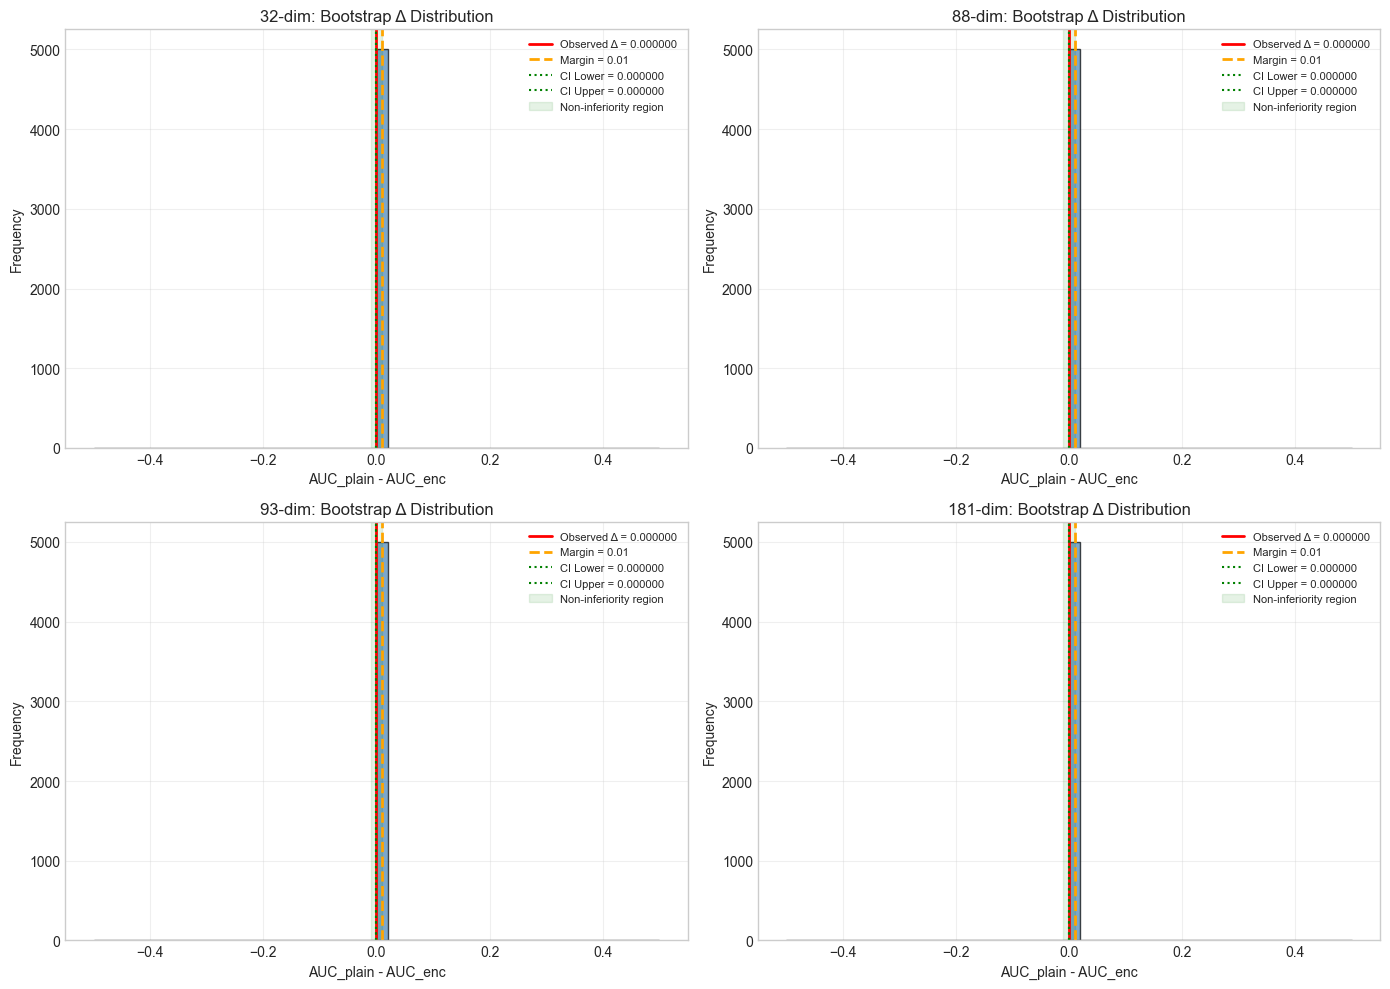


Saved bootstrap distribution figure to artifacts/encrypted_inference/bootstrap_distributions.png


In [9]:
bootstrap_distributions = []

for data in noninferiority_data:
    result = paired_bootstrap_noninferiority(
        data['y_true'],
        data['probs_plain'],
        data['probs_enc'],
        n_boot=5000,
        margin=0.01,
        alpha=0.05,
        random_state=42
    )
    bootstrap_distributions.append({
        'dataset': data['dataset'],
        'deltas': result['deltas'],
        'delta_hat': result['delta_hat'],
        'ci_lower': result['ci_lower'],
        'ci_upper': result['ci_upper']
    })

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, dist in enumerate(bootstrap_distributions):
    ax = axes[idx]
    
    # Histogram of bootstrap deltas
    ax.hist(dist['deltas'], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    
    # Vertical lines
    ax.axvline(dist['delta_hat'], color='red', linestyle='-', linewidth=2, label=f'Observed Δ = {dist["delta_hat"]:.6f}')
    ax.axvline(0.01, color='orange', linestyle='--', linewidth=2, label='Margin = 0.01')
    ax.axvline(dist['ci_lower'], color='green', linestyle=':', linewidth=1.5, label=f'CI Lower = {dist["ci_lower"]:.6f}')
    ax.axvline(dist['ci_upper'], color='green', linestyle=':', linewidth=1.5, label=f'CI Upper = {dist["ci_upper"]:.6f}')
    
    # Shading for non-inferiority region (delta < 0.01)
    ax.axvspan(-0.01, 0.01, alpha=0.1, color='green', label='Non-inferiority region')
    
    ax.set_xlabel('AUC_plain - AUC_enc')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{dist["dataset"]}: Bootstrap Δ Distribution')
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
bootstrap_fig_path = ARTIFACT_DIR / 'bootstrap_distributions.png'
plt.savefig(bootstrap_fig_path, dpi=150)
plt.show()
print(f'\nSaved bootstrap distribution figure to {bootstrap_fig_path}')